In [19]:
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob 

import tensorflow as tf

plt.set_cmap('gray')

gesture_types = ["open", "close", "point", "v", "horns", "three"]


<Figure size 432x288 with 0 Axes>

## Loading data

In [20]:
def get_image(coords: np.ndarray, size = 32):
    black = np.zeros((size,size), dtype=np.int0)
    coords = np.round(coords * size).astype(np.int0) + 5 
    y = coords[:,0]
    x = coords[:,1]
    black[x,y] = 1
    return black

def get_rand_img():
    return list(set(np.random.randint(0,20, size=20)))[0:5]

def get_random_hands(gesture):
    lst = []
    for name in get_rand_img():
        img = np.loadtxt(f"./gestures/{gesture}/{str(name)}.txt")
        lst.append(img)
    return lst


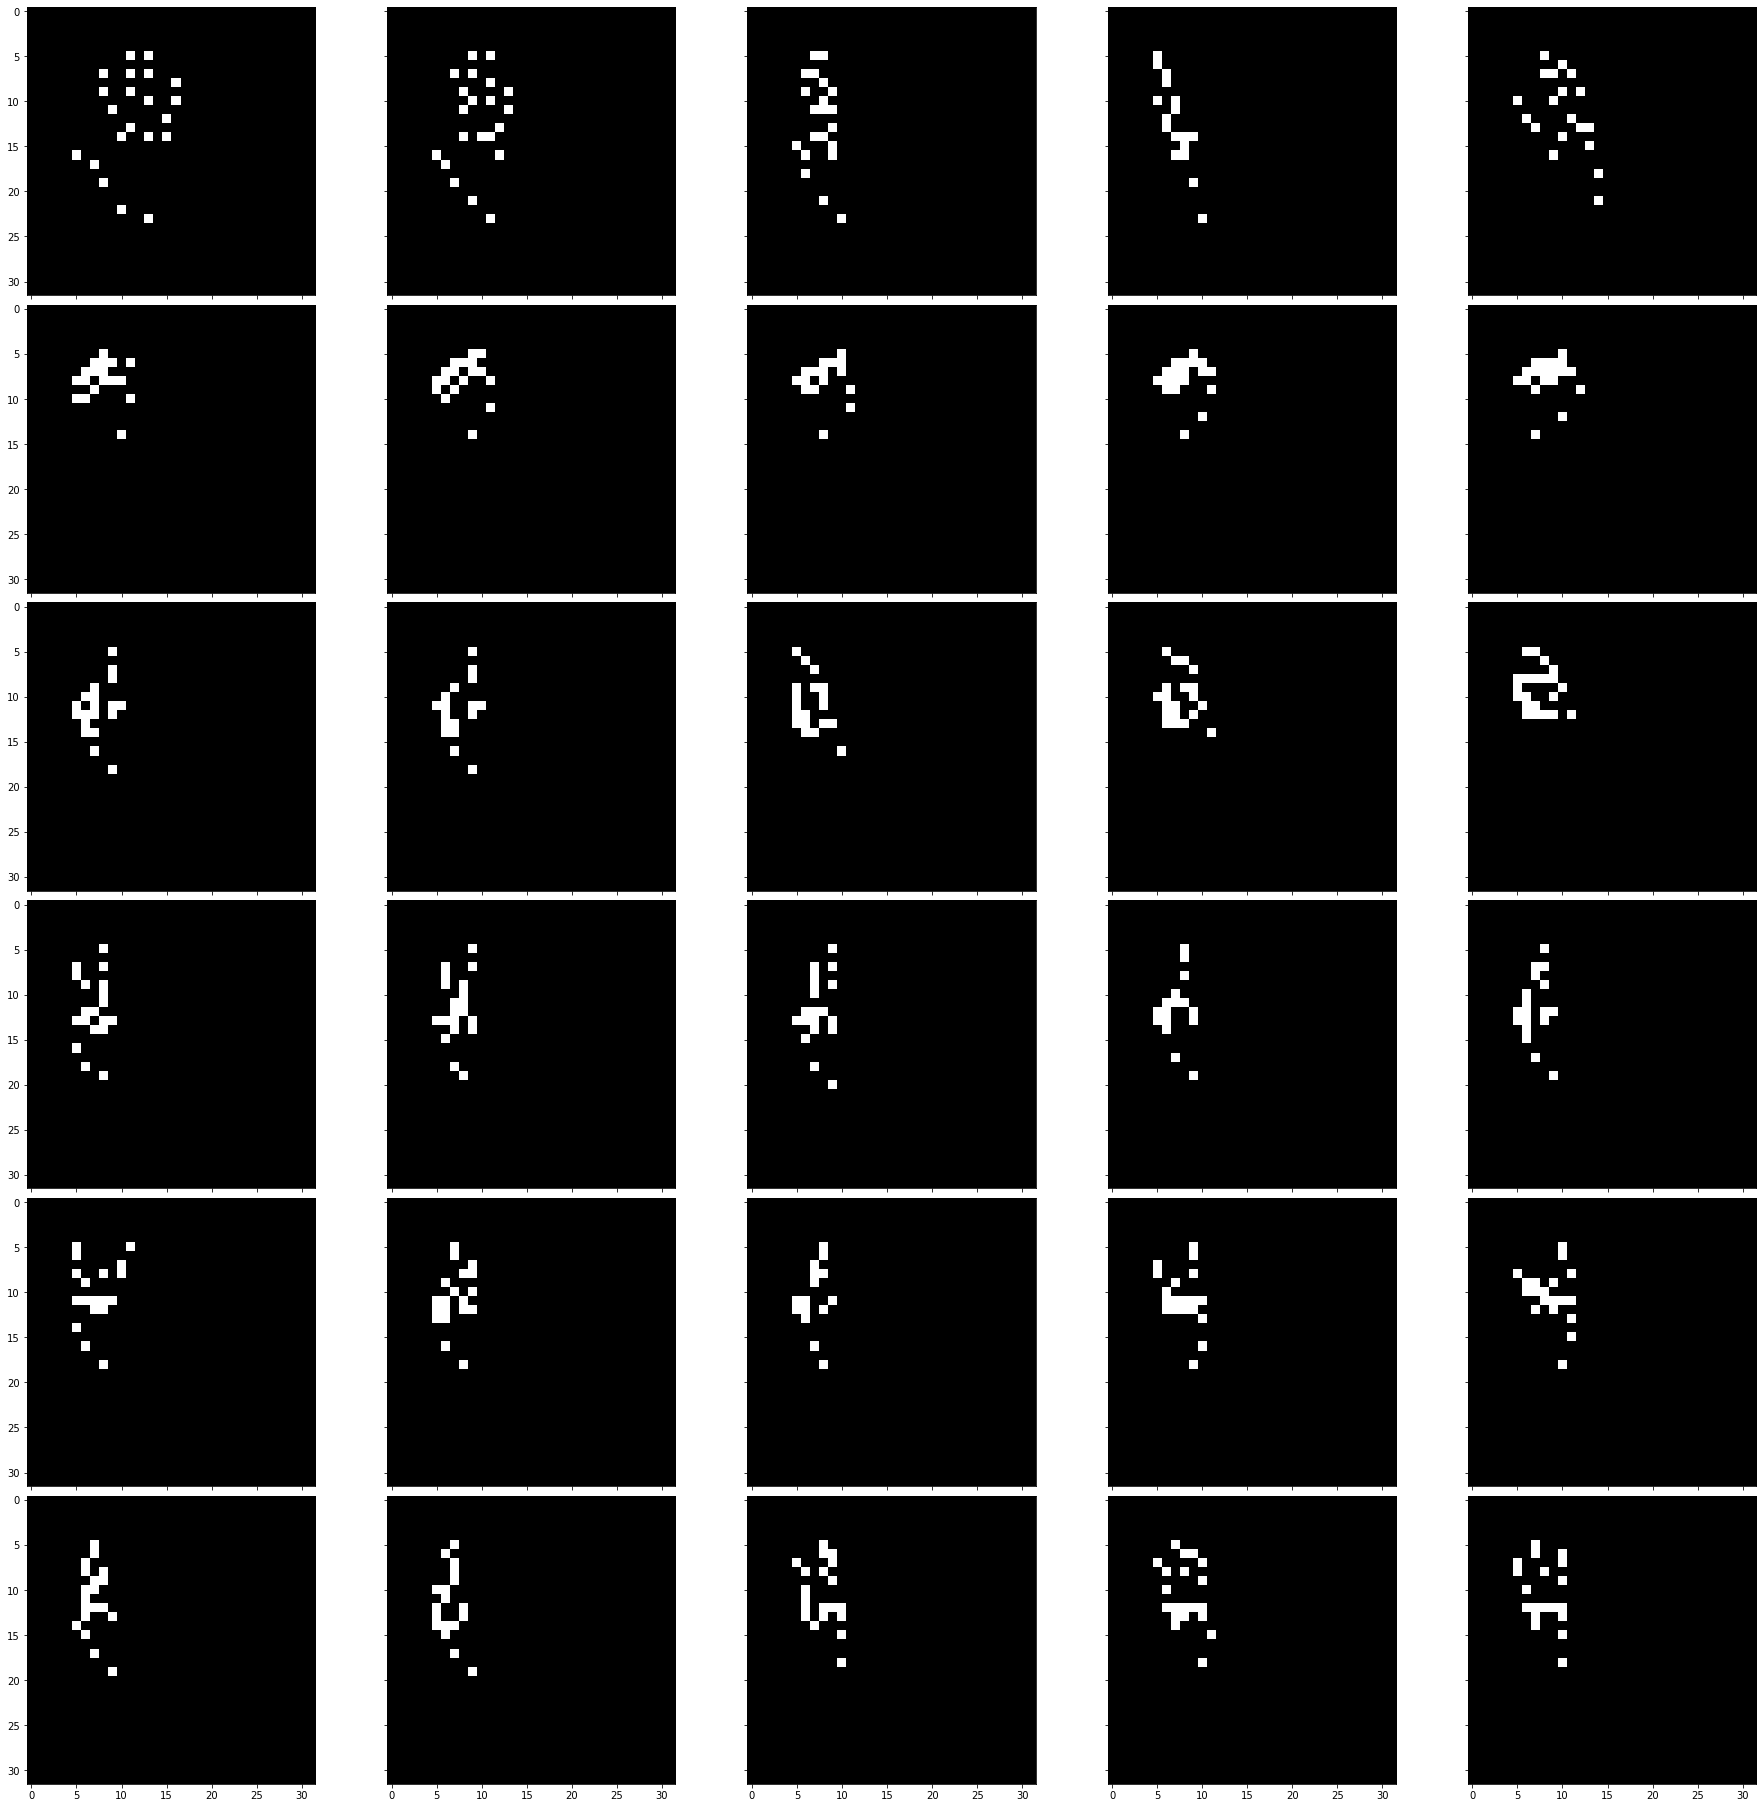

In [21]:
fig, ax = plt.subplots(len(gesture_types),5, sharey=True, sharex=True)
fig.set_constrained_layout(True)
fig.set_size_inches(5*5,5*5)

for iy, gesture_group in enumerate(gesture_types):
    gestures = get_random_hands(gesture_group)
    for ix, gesture in enumerate(gestures):
        ax[iy, ix].imshow(get_image(gesture))

## Loading model 

In [22]:
x_train = []
y_train = []

for iy, gesture_group in enumerate(gesture_types):
    for gesture in glob.glob(f"./gestures/{gesture_group}/*.txt"):
        g = np.loadtxt(gesture)
        x_train.append(g)
        y_train.append(iy)


x_train = np.array(x_train, dtype=np.float64)
y_train = np.array(y_train, dtype=np.int0)

In [23]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(21, 2)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10),
    ]
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])


In [24]:
np.array(y_train).dtype

dtype('int64')

In [25]:
indices = tf.range(start=0, limit=tf.shape(x_train)[0], dtype=tf.int32)

for _ in range(10):
    idx = tf.random.shuffle(indices)
    x = tf.gather(x_train, idx)
    y = tf.gather(y_train, idx)

    model.fit(x, y, epochs=100, verbose=0)


## Getting test Data

In [26]:
random_ixes = np.random.randint(0, 150, 400)

x_test = []
y_test = []

for ix in random_ixes:
    x_test.append(x_train[ix])
    y_test.append(y_train[ix])


x_test = np.array(x_test, dtype=np.float64)
y_test = np.array(y_test, dtype=np.int0)

f"{x_test.shape =} - {y_test.shape = }"

'x_test.shape =(400, 21, 2) - y_test.shape = (400,)'

In [27]:
model.evaluate(x_test,  y_test, verbose=2)

13/13 - 0s - loss: 0.0083 - accuracy: 1.0000 - 110ms/epoch - 8ms/step


[0.008262074552476406, 1.0]

In [28]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [29]:
start = 60
end = start + 10
res = probability_model(x_test[start:end])

# if sum is not 0 we have issue
y_test[start:end] - np.argmax(res, axis=1) 


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### testing with img data

In [30]:
from handProcessor import HandProcessor


images = [cv.imread(f) for f in glob.glob("img/*")]
hands = HandProcessor(min_detection_confidence=0.7)

def prep_subplot(l=len(images)):
    fig, ax = plt.subplots(1, l)
    fig.set_tight_layout(True)

    fig.set_size_inches(24 * 2, 24)
    [a.set_axis_off() for a in ax.ravel()]

    return fig, ax

def prep_hand(img):
    hands.proc(img)
    hand_lm = hands.get_landmark_as_np_arr()
    return hand_lm[0,:] - np.min(hand_lm[0,:], axis=0)

In [31]:
processed_images = np.array([prep_hand(img[:, ::-1, ::-1]) for img in images])
res = probability_model(processed_images)


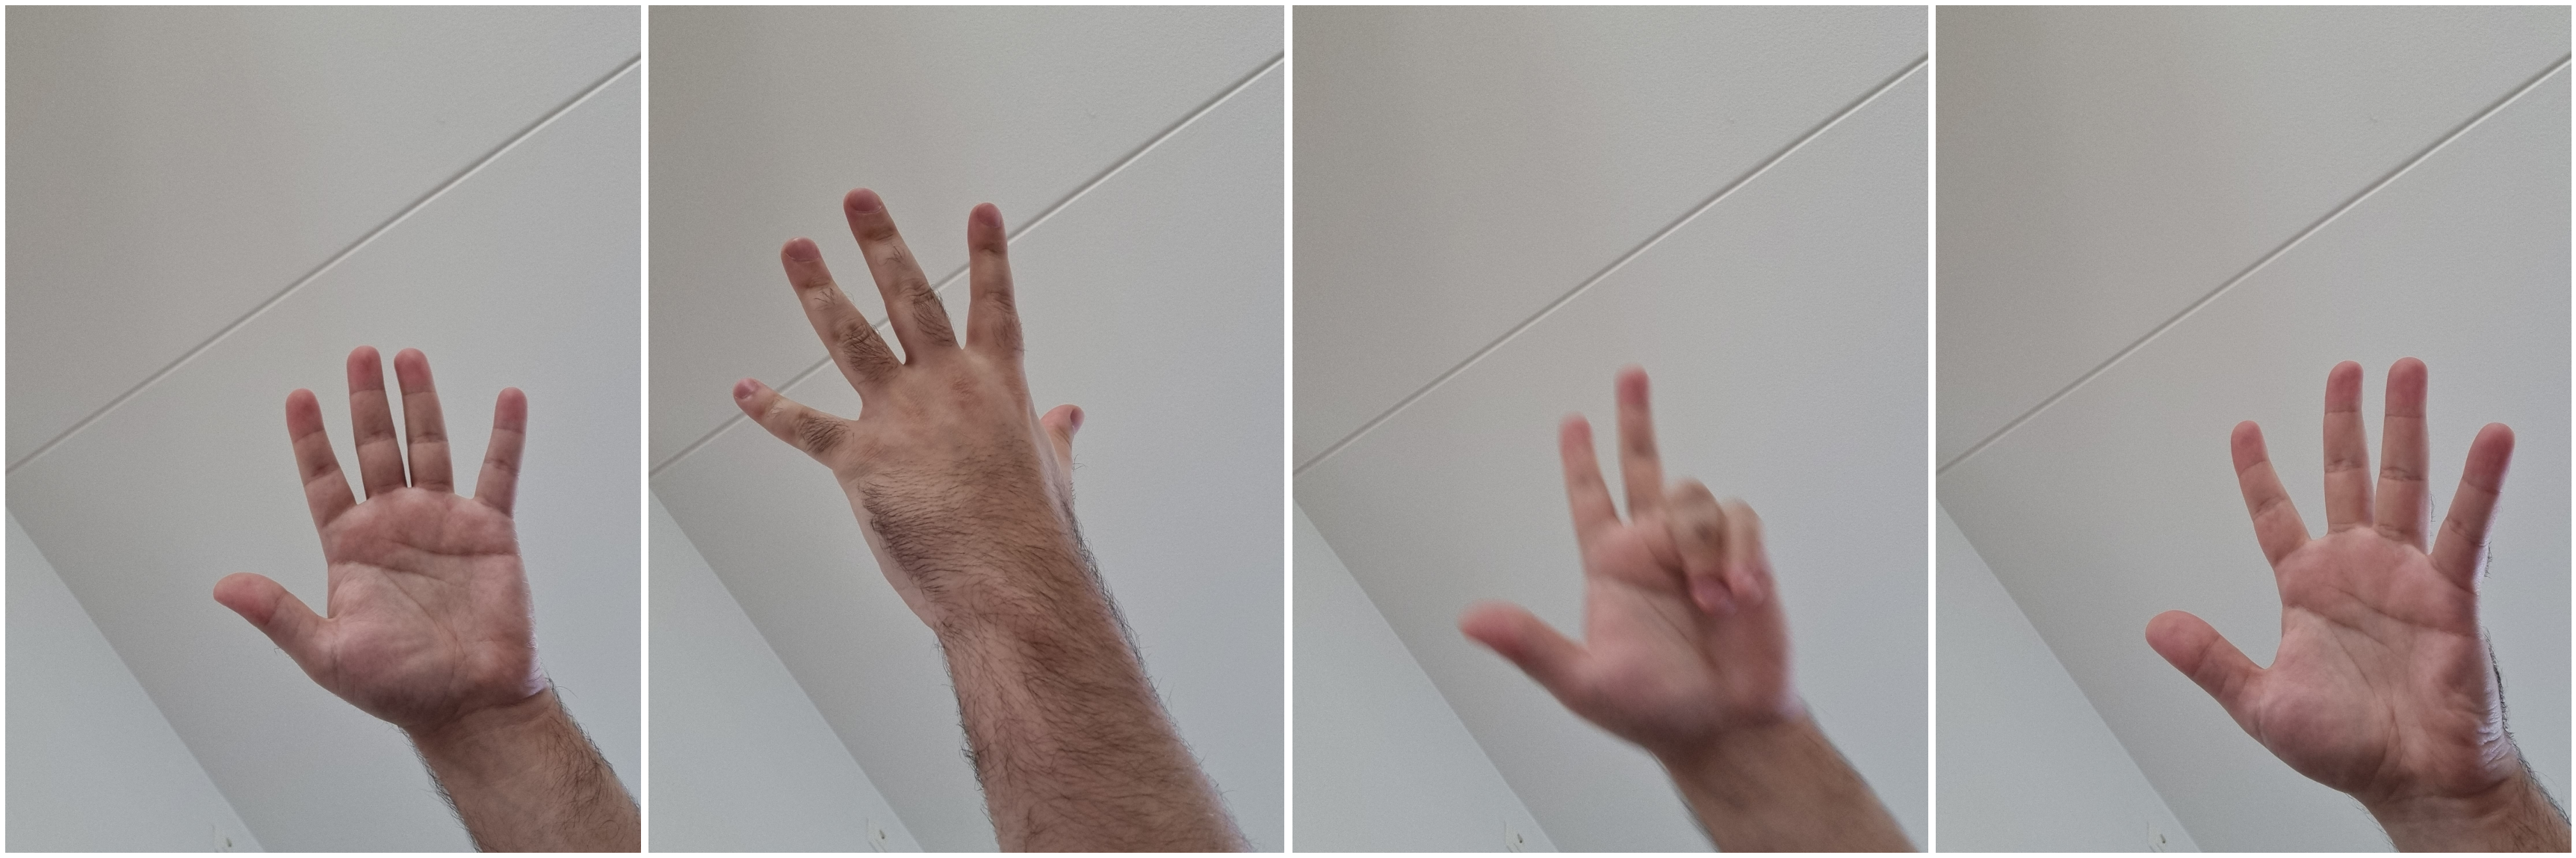

In [32]:
fig, ax = prep_subplot()
_ = [ax[ix].imshow(img[:, ::-1, ::-1]) for ix, img in enumerate(images)]


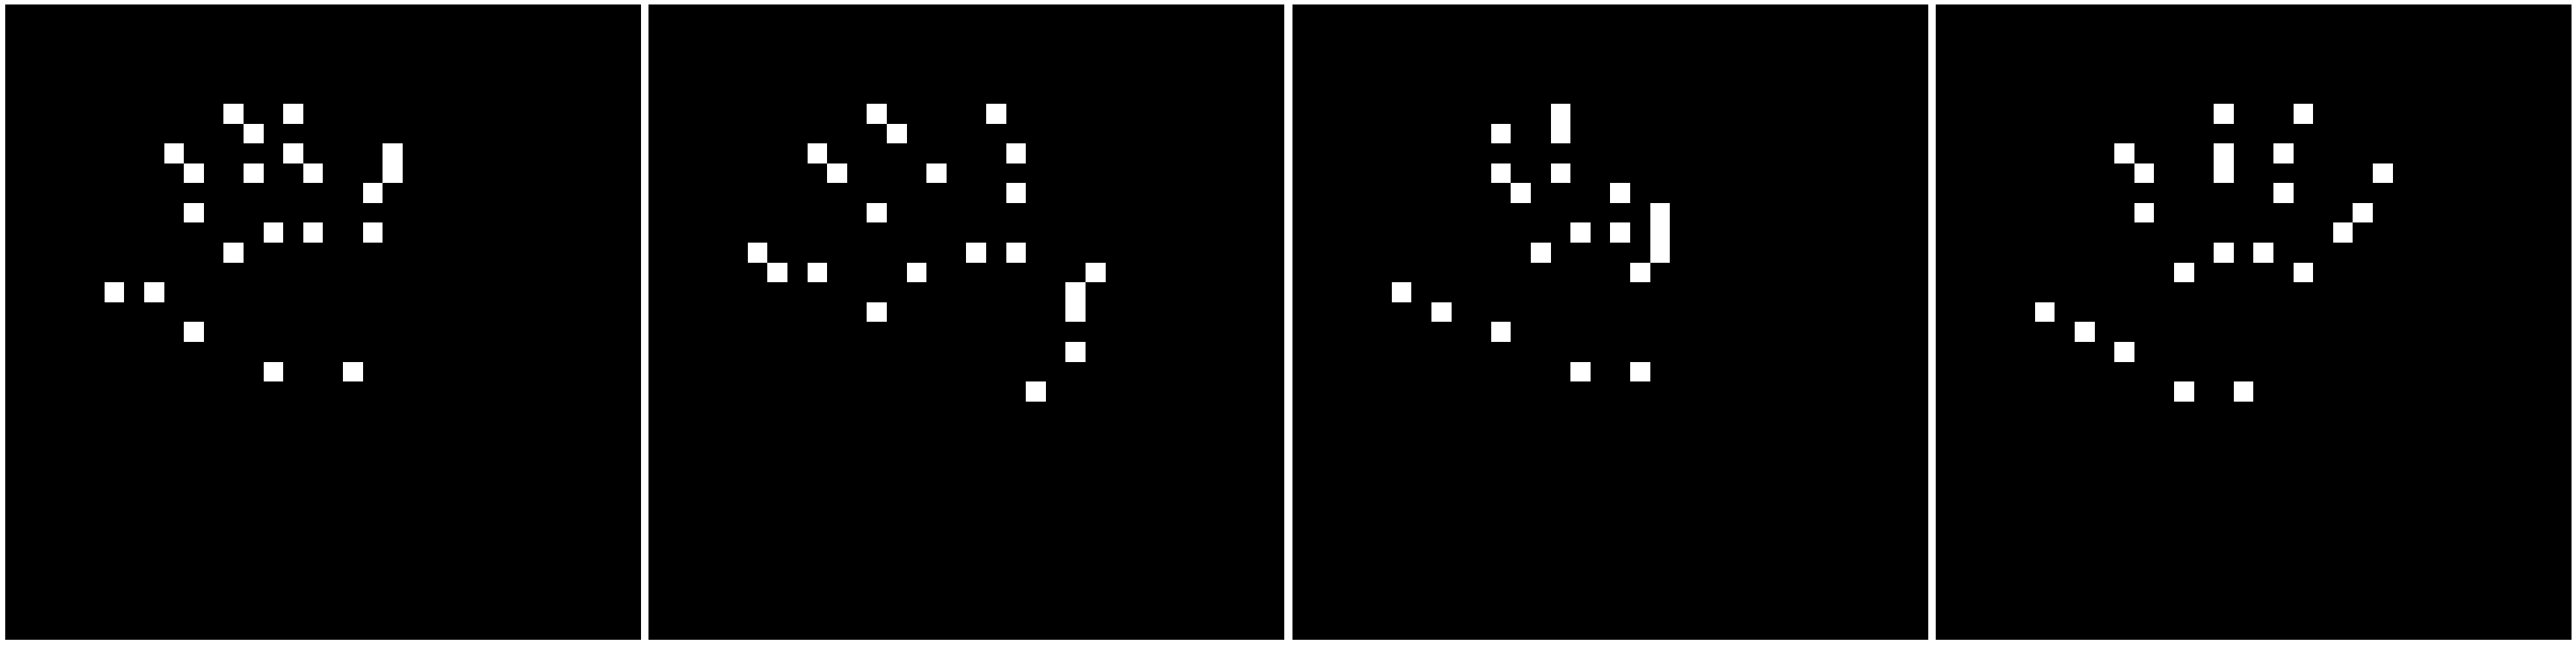

In [33]:
fig, ax = prep_subplot()
_ = [ax[ix].imshow(get_image(img)) for ix, img in enumerate(processed_images)]


In [34]:
[gesture_types[ix] for ix in np.argmax(res, axis=1)]


['open', 'three', 'three', 'open']